In [5]:
# Required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler, scale
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.utils import resample

from imblearn.under_sampling import RandomUnderSampler, NearMiss, EditedNearestNeighbours
from itertools import cycle

import joblib
import pickle

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Load the CTU_13 dataset
df_CTU_13 = pd.read_csv('CTU_13.csv', index_col=0)

# Display the dataset
df_CTU_13


,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:59.607825,1.026539,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
1,2011/08/10 09:47:00.634364,1.009595,tcp,94.44.127.113,1577,->,147.32.84.59,6881,S_RA,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
2,2011/08/10 09:47:48.185538,3.056586,tcp,147.32.86.89,4768,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
3,2011/08/10 09:47:48.230897,3.111769,tcp,147.32.86.89,4788,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
4,2011/08/10 09:47:48.963351,3.083411,tcp,147.32.86.89,4850,->,77.75.73.33,80,SR_A,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19976695,2011/08/16 09:36:00.710103,0.000000,udp,147.32.84.229,13363,->,125.14.162.10,27460,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976696,2011/08/16 09:36:00.777160,0.000427,udp,213.146.167.54,20856,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
19976697,2011/08/16 09:36:00.784094,0.000000,udp,147.32.84.229,13363,->,122.121.0.92,12923,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976698,2011/08/16 09:36:00.784160,0.000000,udp,147.32.84.229,13363,->,110.233.175.133,37690,INT,0.0,NaN,1,476,476,flow=Background-UDP-Attempt


In [6]:
df_CTU_13.isnull().sum()

StartTime          0
Dur                0
Proto              0
SrcAddr            0
Sport         203075
Dir                0
DstAddr            0
Dport         194048
State           1378
sTos          220518
dTos         1717996
TotPkts            0
TotBytes           0
SrcBytes           0
Label              0
dtype: int64

In [7]:
df_CTU_13 = df_CTU_13.drop(['StartTime','SrcAddr','Sport','DstAddr','Dport','State'], axis=1)
df_CTU_13

,Dur,Proto,Dir,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,1.026539,tcp,->,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
1,1.009595,tcp,->,0.0,0.0,4,276,156,flow=Background-Established-cmpgw-CVUT
2,3.056586,tcp,->,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
3,3.111769,tcp,->,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
4,3.083411,tcp,->,0.0,0.0,3,182,122,flow=Background-TCP-Attempt
...,...,...,...,...,...,...,...,...,...
19976695,0.000000,udp,->,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976696,0.000427,udp,<->,0.0,0.0,2,135,75,flow=Background-UDP-Established
19976697,0.000000,udp,->,0.0,NaN,1,476,476,flow=Background-UDP-Attempt
19976698,0.000000,udp,->,0.0,NaN,1,476,476,flow=Background-UDP-Attempt


In [8]:
# Replace all NaN values with the number 9
df_CTU_13 = df_CTU_13.fillna(9)

# Display the dataset
df_CTU_13

# Confirm that there are no missing values remaining
df_CTU_13.isnull().sum()


Dur         0
Proto       0
Dir         0
sTos        0
dTos        0
TotPkts     0
TotBytes    0
SrcBytes    0
Label       0
dtype: int64

In [9]:
# Convert label strings to numeric values for modeling
lst = []
for i in df_CTU_13['Label']:
    if 'Botnet' in i:
        lst.append(1)
    elif 'Normal' in i:
        lst.append(2)
    else:
        lst.append(0)

# Update the DataFrame with numeric labels
df_CTU_13['Label'] = lst

# Display count of each label
df_CTU_13['Label'].value_counts()


Label
0    19175551
1      444699
2      356433
Name: count, dtype: int64

In [10]:
# Convert protocol names to standard IP numeric values
protocol_number = []
for i in df_CTU_13['Proto']:
    if i == 'udp':
        protocol_number.append(17)
    elif i == 'tcp':
        protocol_number.append(6)
    elif i == 'icmp':
        protocol_number.append(1)
    else:
        protocol_number.append(0)

# Update the DataFrame with numeric protocol values
df_CTU_13['Proto'] = protocol_number


In [11]:
# Convert direction symbols to numeric values
# '<->' = 1, '->' = 2, others = 0
direction_number = []
for i in df_CTU_13['Dir']:
    if i == '  <->':
        direction_number.append(1)
    elif i == '   ->':
        direction_number.append(2)
    else:
        direction_number.append(0)

# Update the DataFrame with numeric direction values
df_CTU_13['Dir'] = direction_number

# Display the updated dataset
df_CTU_13


,Dur,Proto,Dir,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,1.026539,6,2,0.0,0.0,4,276,156,0
1,1.009595,6,2,0.0,0.0,4,276,156,0
2,3.056586,6,2,0.0,0.0,3,182,122,0
3,3.111769,6,2,0.0,0.0,3,182,122,0
4,3.083411,6,2,0.0,0.0,3,182,122,0
...,...,...,...,...,...,...,...,...,...
19976695,0.000000,17,2,0.0,9.0,1,476,476,0
19976696,0.000427,17,1,0.0,0.0,2,135,75,0
19976697,0.000000,17,2,0.0,9.0,1,476,476,0
19976698,0.000000,17,2,0.0,9.0,1,476,476,0


In [12]:
A = df_CTU_13.copy()

In [13]:
X_new_df = A.drop(['Label'], axis=1).copy()
y = A['Label'].copy()

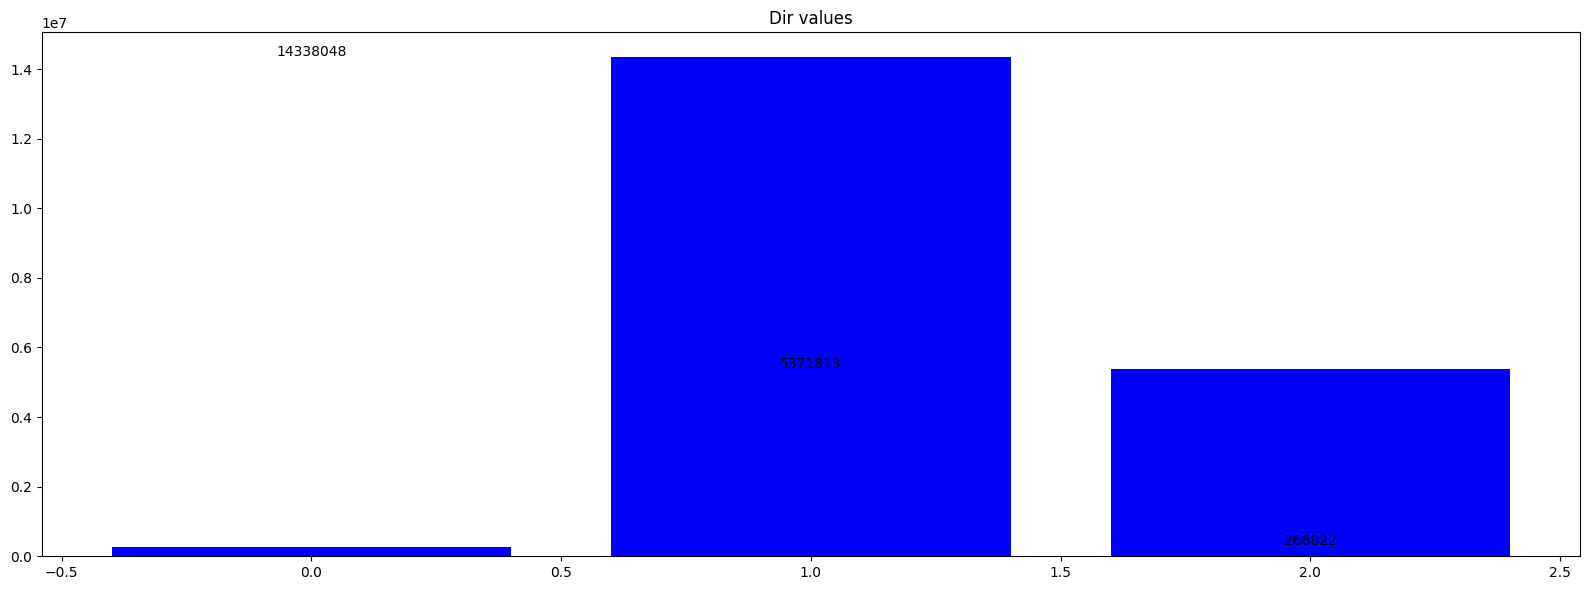

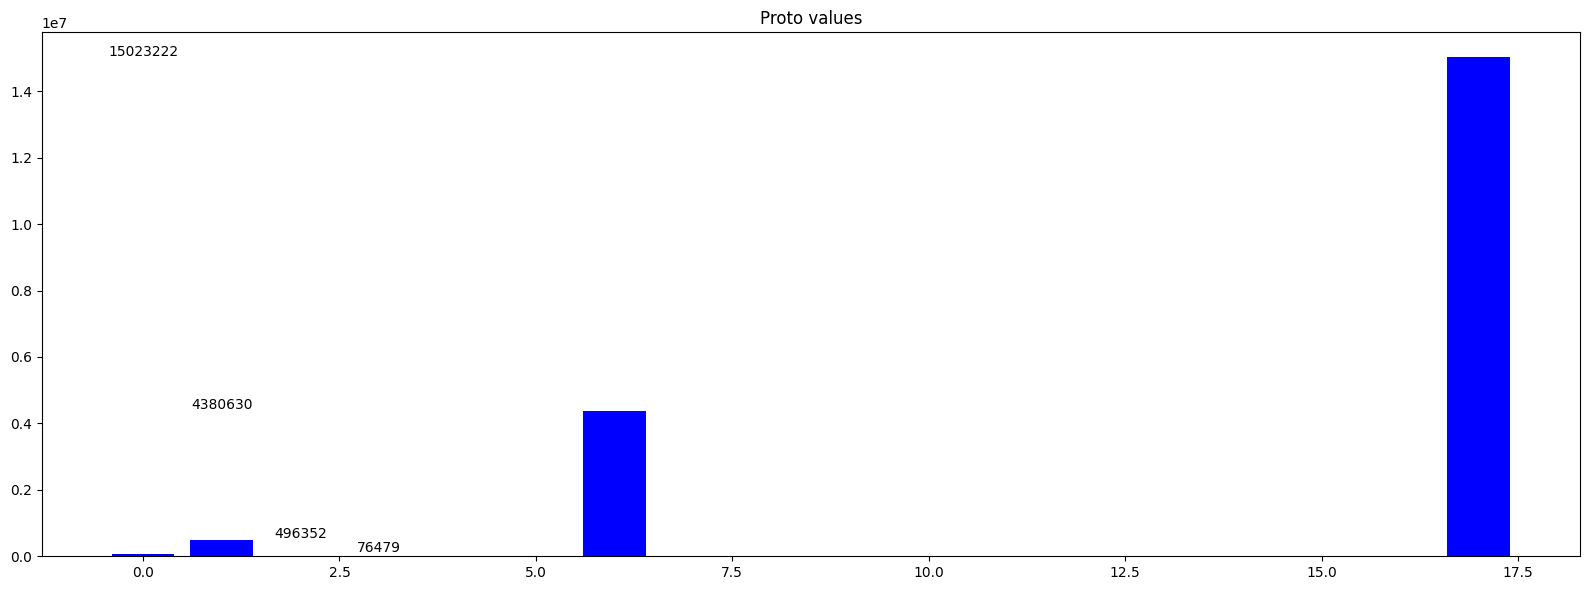

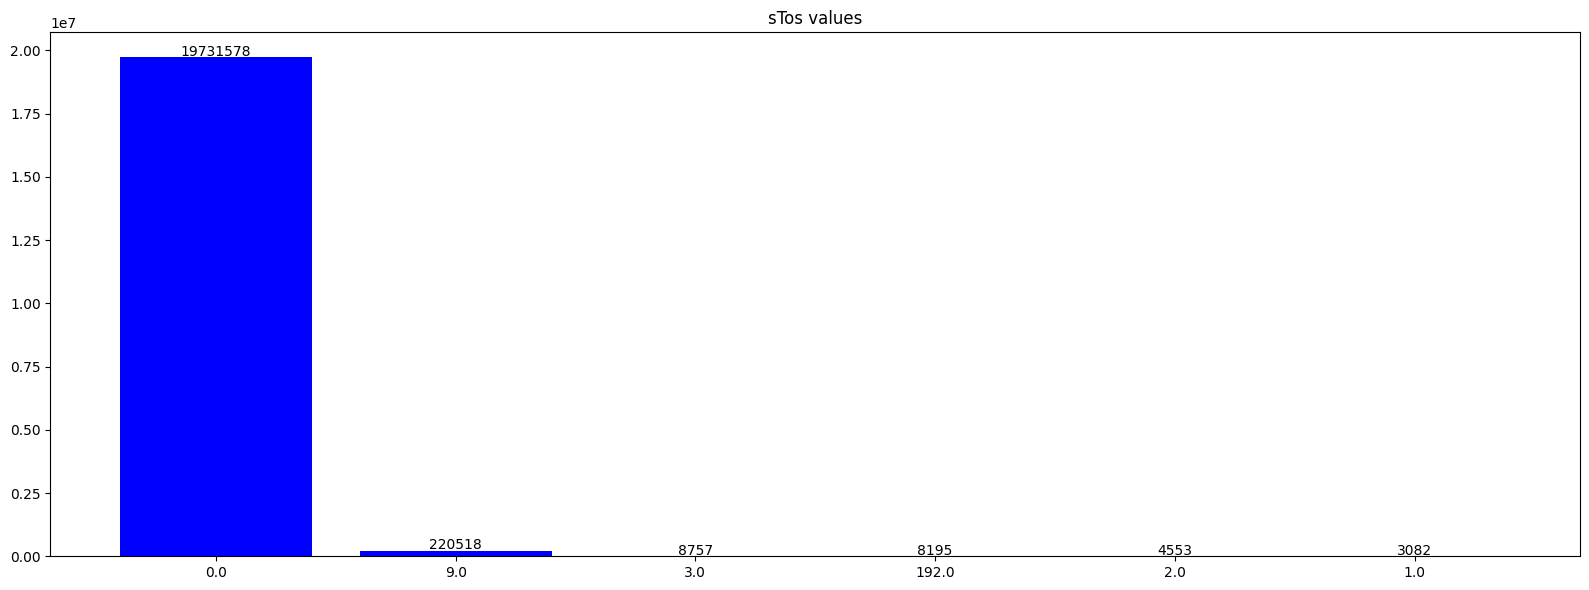

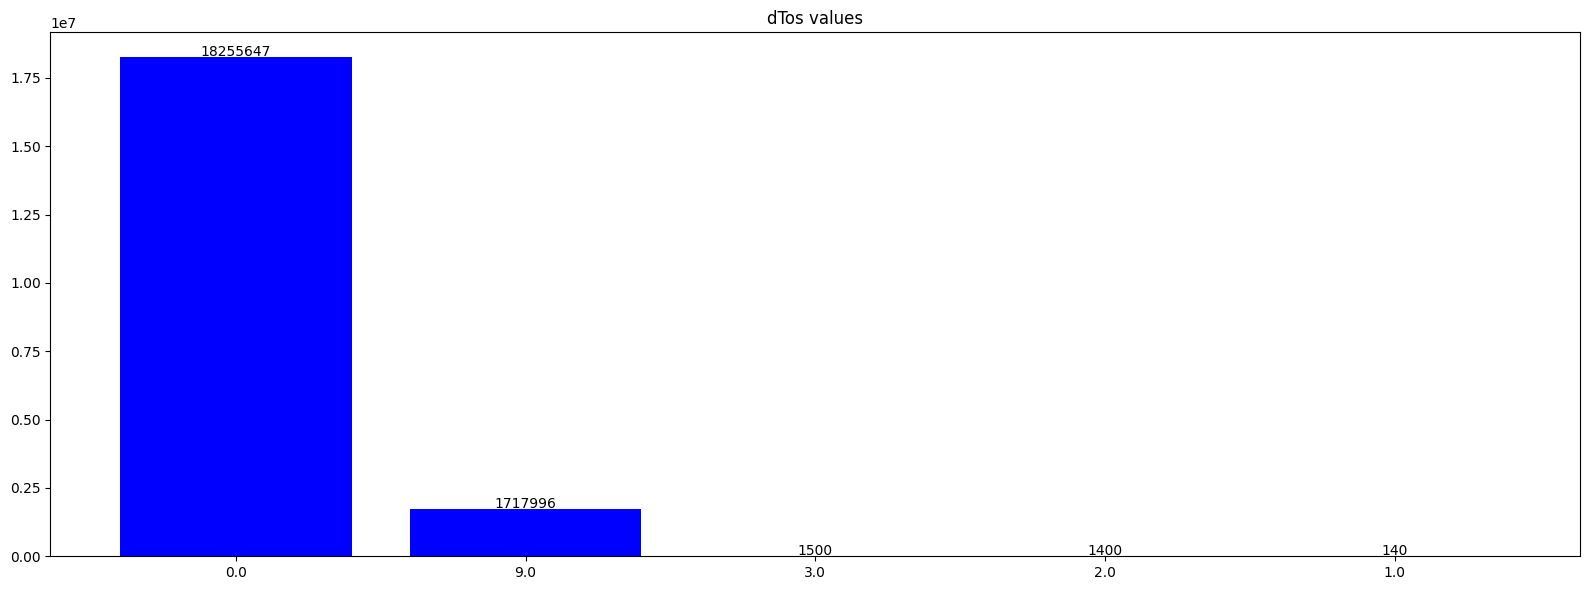

In [14]:
def draw_plot(col):
    # Convert to string for proper categorical plotting if needed
    if col.name == 'sTos' or col.name == 'dTos':
        col = col.astype('str')
    
    names = col.value_counts().index.tolist()  # Unique values
    values = col.value_counts().tolist()       # Counts
    
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.bar(names, values, color='Blue')
    ax.set_title(f'{col.name} values')
    
    # Add count labels on top of bars
    for index, data in enumerate(values):
        plt.text(x=index, y=data + 50000, s=f"{data}", fontsize=10, ha='center')
    
    plt.tight_layout()
    plt.show()

one_hot_lst = ['Dir', 'Proto', 'sTos', 'dTos']
for col_name in one_hot_lst:
    draw_plot(A[col_name])


In [16]:
one_hot_lst = ['Dir','Proto','sTos','dTos']
column_list = ['Dur','TotPkts','TotBytes','SrcBytes',
               'Dir_   ->','Dir_  <->','Dir_others',
	             'Proto_icmp','Proto_tcp','Proto_udp','Proto_others',
               'sTos_0.0','sTos_9.0','sTos_others','dTos_0.0','dTos_9.0','dTos_others','Label']
def one_hot_encoding(df):
    df_new = pd.DataFrame()
    other_list = []
    for i in one_hot_lst:
        if i == 'Dir':
            for j in df[i]:
                if j == '  <->' or j == '   ->':
                    other_list.append(0)  # Known categories
                else:
                    other_list.append(1)  # "Others" category
            other_name = 'Dir_others'
            df[other_name] = other_list
            other_list.clear()
            df_new = pd.get_dummies(df, columns=[i])  # One-hot encode 'Dir'

        elif i == 'Proto':
            for j in df[i]:
                if j in ['tcp', 'udp', 'icmp']:
                    other_list.append(0)
                else:
                    other_list.append(1)
            other_name = 'Proto_others'
            df_new[other_name] = other_list
            other_list.clear()
            df_new = pd.get_dummies(df_new, columns=[i])  # One-hot encode 'Proto'

        elif i == 'sTos':
            for j in df[i]:
                if j == 0 or j == 9:
                    other_list.append(0)
                else:
                    other_list.append(1)
            other_name = 'sTos_others'
            df_new[other_name] = other_list
            other_list.clear()
            df_new = pd.get_dummies(df_new, columns=[i])  # One-hot encode 'sTos'

        elif i == 'dTos':
            for j in df[i]:
                if j == 0 or j == 9:
                    other_list.append(0)
                else:
                    other_list.append(1)
            other_name = 'dTos_others'
            df_new[other_name] = other_list
            other_list.clear()
            df_new = pd.get_dummies(df_new, columns=[i])  # One-hot encode 'dTos'

    # Keep only the columns in column_list, drop all others
    for col in df_new.columns:
        if col not in column_list:
            df_new = df_new.drop([col], axis=1)
    return df_new
A = one_hot_encoding(A)


In [17]:
X = A.drop(['Label'], axis=1).copy()
y = A['Label'].copy()


In [18]:
X_new = SelectKBest(chi2, k=10).fit_transform(X, y)
print(X_new.shape)
X_new

(19976683, 10)


array([[1.026539e+00, 4.000000e+00, 2.760000e+02, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [1.009595e+00, 4.000000e+00, 2.760000e+02, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [3.056586e+00, 3.000000e+00, 1.820000e+02, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 1.000000e+00, 4.760000e+02, ..., 0.000000e+00,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 1.000000e+00, 4.760000e+02, ..., 0.000000e+00,
        0.000000e+00, 1.000000e+00],
       [8.000000e-06, 2.000000e+00, 1.400000e+02, ..., 0.000000e+00,
        0.000000e+00, 1.000000e+00]])

In [19]:
X_new_df = pd.DataFrame(X_new)
X_new_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07
mean,2.879466e+02,4.139078e+01,3.232714e+04,6.435327e+03,1.230785e-03,9.877304e-01,1.103877e-02,1.521774e-04,9.138478e-01,8.600006e-02
std,8.318068e+02,5.545727e+03,3.983039e+06,1.667901e+06,3.506095e-02,1.100864e-01,1.044840e-01,1.233508e-02,2.805887e-01,2.803641e-01
min,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.750000e-04,2.000000e+00,2.140000e+02,7.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,7.270000e-04,2.000000e+00,2.640000e+02,8.300000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,1.966016e+00,4.000000e+00,6.190000e+02,3.040000e+02,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,3.657061e+03,1.658064e+07,4.376239e+09,3.423408e+09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [20]:
X_new = SelectKBest(f_classif, k=10).fit_transform(X, y)
print(X_new.shape)
X_new

(19976683, 10)


array([[1.026539e+00, 4.000000e+00, 2.760000e+02, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [1.009595e+00, 4.000000e+00, 2.760000e+02, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       [3.056586e+00, 3.000000e+00, 1.820000e+02, ..., 0.000000e+00,
        1.000000e+00, 0.000000e+00],
       ...,
       [0.000000e+00, 1.000000e+00, 4.760000e+02, ..., 0.000000e+00,
        0.000000e+00, 1.000000e+00],
       [0.000000e+00, 1.000000e+00, 4.760000e+02, ..., 0.000000e+00,
        0.000000e+00, 1.000000e+00],
       [8.000000e-06, 2.000000e+00, 1.400000e+02, ..., 0.000000e+00,
        0.000000e+00, 1.000000e+00]])

In [21]:
X_new_df = pd.DataFrame(X_new)
X_new_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07,1.997668e+07
mean,2.879466e+02,4.139078e+01,3.232714e+04,6.435327e+03,1.230785e-03,9.877304e-01,1.103877e-02,1.521774e-04,9.138478e-01,8.600006e-02
std,8.318068e+02,5.545727e+03,3.983039e+06,1.667901e+06,3.506095e-02,1.100864e-01,1.044840e-01,1.233508e-02,2.805887e-01,2.803641e-01
min,0.000000e+00,1.000000e+00,6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.750000e-04,2.000000e+00,2.140000e+02,7.800000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,7.270000e-04,2.000000e+00,2.640000e+02,8.300000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,1.966016e+00,4.000000e+00,6.190000e+02,3.040000e+02,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,3.657061e+03,1.658064e+07,4.376239e+09,3.423408e+09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [22]:
rus = RandomUnderSampler(random_state=0, sampling_strategy={0: 801132, 1: 444699, 2: 356433})
X_res, y_res = rus.fit_resample(X_new_df, y)

In [23]:
y_res.value_counts()

Label
0    801132
1    444699
2    356433
Name: count, dtype: int64

In [24]:
X_res

,0,1,2,3,4,5,6,7,8,9
16918045,0.000271,2.0,214.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
17825641,0.000223,2.0,214.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
4056545,0.000242,2.0,214.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
4521934,0.000246,2.0,214.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
11103580,0.000366,2.0,214.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
17301437,0.000145,2.0,233.0,74.0,0.0,1.0,0.0,0.0,1.0,0.0
8513634,0.000229,2.0,244.0,81.0,0.0,1.0,0.0,0.0,1.0,0.0
5886829,0.000357,2.0,400.0,74.0,0.0,1.0,0.0,0.0,1.0,0.0
15814944,18.002481,6.0,412.0,272.0,0.0,1.0,0.0,0.0,1.0,0.0


In [25]:
nearmiss = NearMiss(version=1, sampling_strategy={0: 801132, 1: 444699, 2: 356433})
X_res, y_res = nearmiss.fit_resample(X_new_df, y)

In [26]:
y_res.value_counts()

Label
0    801132
1    444699
2    356433
Name: count, dtype: int64

In [27]:
X_res

,0,1,2,3,4,5,6,7,8,9
0,0.000000,1.0,74.0,74.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,1.0,135.0,135.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.000000,1.0,135.0,135.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.000000,1.0,145.0,145.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.000000,1.0,173.0,173.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
1602259,2343.518311,32743.0,28731392.0,27871226.0,0.0,1.0,0.0,0.0,1.0,0.0
1602260,1331.276367,64778.0,84571124.0,84023978.0,0.0,1.0,0.0,0.0,1.0,0.0
1602261,1805.375000,104956.0,137416417.0,136546777.0,0.0,1.0,0.0,0.0,1.0,0.0
1602262,3268.395996,212578.0,250218422.0,3039208.0,0.0,1.0,0.0,0.0,1.0,0.0


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.8, test_size=0.2, random_state=0)

In [29]:
 X_test.value_counts()

0            1     2       3       4    5    6    7    8    9  
0.000000     1.0   1066.0  1066.0  0.0  1.0  0.0  0.0  0.0  1.0    20847
                   66.0    66.0    0.0  1.0  0.0  0.0  0.0  1.0     8886
                   62.0    62.0    0.0  1.0  0.0  0.0  0.0  1.0     6130
                   145.0   145.0   0.0  1.0  0.0  0.0  0.0  1.0     4945
                   173.0   173.0   0.0  1.0  0.0  0.0  0.0  1.0     3983
                                                                   ...  
3599.179932  18.0  1620.0  810.0   0.0  1.0  0.0  0.0  1.0  0.0        1
3599.203613  18.0  1620.0  810.0   0.0  1.0  0.0  0.0  1.0  0.0        1
3599.256592  18.0  1620.0  810.0   0.0  1.0  0.0  0.0  1.0  0.0        1
3599.310303  18.0  1620.0  810.0   0.0  1.0  0.0  0.0  1.0  0.0        1
10.651059    11.0  1877.0  1288.0  0.0  1.0  0.0  0.0  1.0  0.0        1
Name: count, Length: 99441, dtype: int64

In [30]:
y_test.value_counts()

Label
0    160263
1     89045
2     71145
Name: count, dtype: int64

In [31]:
X_train.value_counts()

0            1      2        3        4    5    6    7    8    9  
0.000000     1.0    1066.0   1066.0   0.0  1.0  0.0  0.0  0.0  1.0    83454
                    66.0     66.0     0.0  1.0  0.0  0.0  0.0  1.0    36417
                    62.0     62.0     0.0  1.0  0.0  0.0  0.0  1.0    24325
                    145.0    145.0    0.0  1.0  0.0  0.0  0.0  1.0    19687
                    173.0    173.0    0.0  1.0  0.0  0.0  0.0  1.0    16010
                                                                      ...  
3599.979736  620.0  85848.0  58482.0  0.0  1.0  0.0  0.0  1.0  0.0        1
3599.982910  350.0  38108.0  21610.0  0.0  1.0  0.0  0.0  1.0  0.0        1
3599.988037  307.0  29270.0  17900.0  0.0  1.0  0.0  0.0  1.0  0.0        1
3599.992432  26.0   1560.0   780.0    0.0  0.0  1.0  0.0  0.0  1.0        1
16.353975    11.0   2563.0   601.0    0.0  1.0  0.0  0.0  1.0  0.0        1
Name: count, Length: 328674, dtype: int64

In [32]:
y_train.value_counts()

Label
0    640869
1    355654
2    285288
Name: count, dtype: int64

In [33]:
# fit scaler on training data
scaler = MinMaxScaler(feature_range=(0,1)).fit(X_train)
# transform training data
X_train = scaler.transform(X_train)
# transform testing dataabs
X_test = scaler.transform(X_test)

In [34]:
# fit scaler on training data
scaler = StandardScaler().fit(X_train)
# transform training data
X_train = scaler.transform(X_train)
# transform testing dataabs
X_test = scaler.transform(X_test)

In [35]:
model_DT = DecisionTreeClassifier(random_state=0)
model_DT.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [36]:
y_predict_DT = model_DT.predict(X_test)
acc_score_DT = accuracy_score(y_test, y_predict_DT)
print("Accuracy score: {} %".format(acc_score_DT*100))
bot_recall_score = recall_score(y_test, y_predict_DT, average=None)[1]
bot_precision_score = precision_score(y_test, y_predict_DT, average=None)[1]
bot_f1_score = f1_score(y_test, y_predict_DT, average=None)[1]
print('Botnet traffic recall score: {}'.format(bot_recall_score))
print('Botnet traffic precision score: {}'.format(bot_precision_score))
print('Botnet traffic f1 score: {}'.format(bot_f1_score))

Accuracy score: 94.21225577541792 %
Botnet traffic recall score: 0.9598517603458925
Botnet traffic precision score: 0.9661775677692116
Botnet traffic f1 score: 0.9630042758877114


In [38]:
y_predict_DT

array([0, 2, 1, ..., 0, 0, 0])

In [39]:
joblib.dump(model_DT, 'saved_models/decision_tree_model.joblib')


['saved_models/decision_tree_model.joblib']

In [40]:
model_RF = RandomForestClassifier(random_state=0)
model_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [42]:
joblib.dump(model_RF, 'saved_models/RandomForestModel.joblib')

['saved_models/RandomForestModel.joblib']

In [43]:
y_predict_RF = model_RF.predict(X_test)
acc_score_RF = accuracy_score(y_test, y_predict_RF)
print("Accuracy score: {} %".format(acc_score_RF*100))
bot_recall_score = recall_score(y_test, y_predict_RF, average=None)[1]
bot_precision_score = precision_score(y_test, y_predict_RF, average=None)[1]
bot_f1_score = f1_score(y_test, y_predict_RF, average=None)[1]
print('Botnet traffic recall score: {}'.format(bot_recall_score))
print('Botnet traffic precision score: {}'.format(bot_precision_score))
print('Botnet traffic f1 score: {}'.format(bot_f1_score))

Accuracy score: 94.68283960518391 %
Botnet traffic recall score: 0.9706103655455107
Botnet traffic precision score: 0.9711884214311399
Botnet traffic f1 score: 0.9708993074473283


In [44]:
model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [45]:
y_predict_KNN = model_KNN.predict(X_test)
acc_score_KNN = accuracy_score(y_test, y_predict_KNN)
print("Accuracy score: {} %".format(acc_score_KNN*100))
bot_recall_score = recall_score(y_test, y_predict_KNN, average=None)[1]
bot_precision_score = precision_score(y_test, y_predict_KNN, average=None)[1]
bot_f1_score = f1_score(y_test, y_predict_KNN, average=None)[1]
print('Botnet traffic recall score: {}'.format(bot_recall_score))
print('Botnet traffic precision score: {}'.format(bot_precision_score))
print('Botnet traffic f1 score: {}'.format(bot_f1_score))

Accuracy score: 94.01253850018567 %
Botnet traffic recall score: 0.9673985063731821
Botnet traffic precision score: 0.963546269057393
Botnet traffic f1 score: 0.9654685451060825


In [46]:
joblib.dump(model_KNN, 'saved_models/KNNModel.joblib')

['saved_models/KNNModel.joblib']